### PoC Proof of Concept - Auslesen Daten Sensoneo Füllstandsensoren
Für PoC wurden die Daten von der Sigfox Plattform in csv-From heruntergeladen. Hier werden die Daten des Füllstandsensors der bei Kompotoi montiert ist ausgelesen 

In [1]:
# import librarys
import pandas as pd
import glob
import os
import numpy as np
import re
import matplotlib.pyplot as plt 
import matplotlib as mpl
#print(plt.style.available)
# optional: for ggplot-like style
mpl.style.use(['ggplot']) 
# damit plt.show() nicht benötigt wird
%matplotlib inline

#### Alle 'page' files im Order einlesen

In [2]:
path_data = r'./data/sensoneo'
# advisable to use os.path.join as this makes concatenation OS independent
all_files = glob.glob(os.path.join(path_data + '/*.csv'))
len(all_files), all_files[0]

(3, './data/sensoneo\\export-device-34EF62-messages_p1.csv')

In [3]:
# lese alle files im Ordner (Achtung: csv file Daten von Plattform mit ; getrennt)
df_sensoneo = pd.concat((pd.read_csv(f, sep=';') for f in all_files), ignore_index=True)
df_sensoneo.head(3)

,Country,Data,Device ID,Timestamp
0,NaN,b92a0070010c0c0c0c6e0c3f,0034EF62,2021-05-04 07:05:30
1,NaN,b92a0070010c0c0c0c6e0a3e,0034EF62,2021-05-04 05:05:31
2,NaN,b92a0070010b0b0b0b6e0a3d,0034EF62,2021-05-04 03:05:27


#### DF fast clean up

In [4]:
# set Timestamp as index
df_sensoneo.index = pd.to_datetime(df_sensoneo['Timestamp'])
# drop na columne country
df_sensoneo.drop('Timestamp', axis=1, inplace=True)
df_sensoneo.drop('Country', axis=1, inplace=True)
df_sensoneo.head(2)

,Data,Device ID
Timestamp,,
2021-05-04 07:05:30,b92a0070010c0c0c0c6e0c3f,0034EF62
2021-05-04 05:05:31,b92a0070010c0c0c0c6e0a3e,0034EF62


In [5]:
#df_sensoneo.loc['2021-4-23']

### System Daten Decodieren

In [6]:
test_string = df_sensoneo['Data'][0]
print(test_string)

b92a0070010c0c0c0c6e0c3f


#### Regex Versuche

In [7]:
# Hex daten aufsplitten
# full_pattern = r'b92a00700\w\w\w\w\w\w\w\w\w\w\w\w\w\w\w'
pat_distance01 = r'b92a00700\w(\w\w)\w\w\w\w\w\w\w\w\w\w\w\w'
pat_distance02 = r'b92a00700\w\w\w(\w\w)\w\w\w\w\w\w\w\w\w\w'
pat_distance03 = r'b92a00700\w\w\w\w\w(\w\w)\w\w\w\w\w\w\w\w'
pat_distance04 = r'b92a00700\w\w\w\w\w\w\w(\w\w)\w\w\w\w\w\w'
pat_voltage    = r'b92a00700\w\w\w\w\w\w\w\w\w(\w\w)\w\w\w\w'
pat_temperatur = r'b92a00700\w\w\w\w\w\w\w\w\w\w\w(\w\w)\w\w'
pat_event_count = r'b92a00700\w{13}(\w\w)'

# Hex-code
hex_distance01 = str(re.findall(pat_distance01, test_string)[0])
hex_distance02 = str(re.findall(pat_distance02, test_string)[0])
hex_distance03 = str(re.findall(pat_distance03, test_string)[0])
hex_distance04 = str(re.findall(pat_distance04, test_string)[0])
hex_voltage    = str(re.findall(pat_voltage, test_string)[0])
hex_temperatur = str(re.findall(pat_temperatur, test_string)[0])
hex_event_count = str(re.findall(pat_event_count, test_string)[0])

# Umrechnungen
distance_cm_01  = int(hex_distance01, 16)*2
distance_cm_02  = int(hex_distance02, 16)*2
distance_cm_03  = int(hex_distance03, 16)*2
distance_cm_04  = int(hex_distance04, 16)*2
voltage_mV  = (int(hex_voltage, 16)*10) + 2500
temperatur  = int(hex_temperatur, 16)
event_count = int(hex_event_count, 16)

print('Distanz [cm] 01: ', distance_cm_01, '\t','Distanz 01(hex): ', '\t', hex_distance01)
print('Distanz [cm] 02: ', distance_cm_02, '\t','Distanz 02(hex): ', '\t', hex_distance02)
print('Distanz [cm] 03: ', distance_cm_03, '\t','Distanz 03(hex): ', '\t', hex_distance03)
print('Distanz [cm] 04: ', distance_cm_04, '\t','Distanz 04(hex): ', '\t', hex_distance04)
print('Spannung [mV]: ', voltage_mV, '\t','Spannung(hex): ', '\t', hex_voltage)
print('Temperatur: ', temperatur, '\t','Temperatur(hex): ', '\t', hex_temperatur)
print('Event Counter: ', event_count, '\t','Event Counter(hex): ', '\t', hex_event_count)

measurements = {'distance':[distance_cm_01,distance_cm_02,distance_cm_03,distance_cm_04], 
                       'Voltage_mV':voltage_mV, 'Temperatur':temperatur, 'Event Count':event_count}
measurements

Distanz [cm] 01:  24 	 Distanz 01(hex):  	 0c
Distanz [cm] 02:  24 	 Distanz 02(hex):  	 0c
Distanz [cm] 03:  24 	 Distanz 03(hex):  	 0c
Distanz [cm] 04:  24 	 Distanz 04(hex):  	 0c
Spannung [mV]:  3600 	 Spannung(hex):  	 6e
Temperatur:  12 	 Temperatur(hex):  	 0c
Event Counter:  63 	 Event Counter(hex):  	 3f


{'distance': [24, 24, 24, 24],
 'Voltage_mV': 3600,
 'Temperatur': 12,
 'Event Count': 63}

In [8]:
# Als Funktion
def data_decoder(data, print_for_debug = False):
    # Hex daten aufsplitten
    # full_pattern = r'b92a00700\w\w\w\w\w\w\w\w\w\w\w\w\w\w\w'
    pat_distance01 = r'b92a00700\w(\w\w)\w\w\w\w\w\w\w\w\w\w\w\w'
    pat_distance02 = r'b92a00700\w\w\w(\w\w)\w\w\w\w\w\w\w\w\w\w'
    pat_distance03 = r'b92a00700\w\w\w\w\w(\w\w)\w\w\w\w\w\w\w\w'
    pat_distance04 = r'b92a00700\w\w\w\w\w\w\w(\w\w)\w\w\w\w\w\w'
    pat_voltage    = r'b92a00700\w\w\w\w\w\w\w\w\w(\w\w)\w\w\w\w'
    pat_temperatur = r'b92a00700\w\w\w\w\w\w\w\w\w\w\w(\w\w)\w\w'
    pat_event_count = r'b92a00700\w{13}(\w\w)'
    
    # Hex-code
    hex_distance01 = str(re.findall(pat_distance01, data)[0])
    hex_distance02 = str(re.findall(pat_distance02, data)[0])
    hex_distance03 = str(re.findall(pat_distance03, data)[0])
    hex_distance04 = str(re.findall(pat_distance04, data)[0])
    hex_voltage    = str(re.findall(pat_voltage, data)[0])
    hex_temperatur = str(re.findall(pat_temperatur, data)[0])
    hex_event_count = str(re.findall(pat_event_count, data)[0])
    
    # Umrechnungen
    distance_cm_01  = int(hex_distance01, 16)*2
    distance_cm_02  = int(hex_distance02, 16)*2
    distance_cm_03  = int(hex_distance03, 16)*2
    distance_cm_04  = int(hex_distance04, 16)*2
    voltage_mV  = (int(hex_voltage, 16)*10) + 2500
    temperatur  = int(hex_temperatur, 16)
    event_count = int(hex_event_count, 16)
    
    if print_for_debug:
        print('Distanz [cm] 01: ', distance_cm_01, '\t','Distanz 01(hex): ', '\t', hex_distance01)
        print('Distanz [cm] 02: ', distance_cm_02, '\t','Distanz 02(hex): ', '\t', hex_distance02)
        print('Distanz [cm] 03: ', distance_cm_03, '\t','Distanz 03(hex): ', '\t', hex_distance03)
        print('Distanz [cm] 04: ', distance_cm_04, '\t','Distanz 04(hex): ', '\t', hex_distance04)
        print('Spannung [mV]: ', voltage_mV, '\t','Spannung(hex): ', '\t', hex_voltage)
        print('Temperatur: ', temperatur, '\t','Temperatur(hex): ', '\t', hex_temperatur)
        print('Event Counter: ', event_count, '\t','Event Counter(hex): ', '\t', hex_event_count)
        
        
    measurements = {'Distance':[distance_cm_01,distance_cm_02,distance_cm_03,distance_cm_04], 
                       'Voltage_mV':voltage_mV, 'Temperatur':temperatur, 'Event_Count':event_count}
    return measurements

In [9]:
sensor_data = data_decoder(test_string, print_for_debug = False)
sensor_data

{'Distance': [24, 24, 24, 24],
 'Voltage_mV': 3600,
 'Temperatur': 12,
 'Event_Count': 63}

### Anwendung Decodieren

In [10]:
# Neue (Mess-)Spalten hinzufügen
df_sensoneo['Distance']    = 0
df_sensoneo['Temperatur']  = 0
df_sensoneo['Spannung mV'] = 0
df_sensoneo['Event Count'] = 0
df_sensoneo.head(2)

,Data,Device ID,Distance,Temperatur,Spannung mV,Event Count
Timestamp,,,,,,
2021-05-04 07:05:30,b92a0070010c0c0c0c6e0c3f,0034EF62,0,0,0,0
2021-05-04 05:05:31,b92a0070010c0c0c0c6e0a3e,0034EF62,0,0,0,0


In [11]:
# Neue (Mess-)Spalten hinzufügen und Daten schreiben (geht nicht)
# df_sensoneo['Distance']    = data_decoder(df_sensoneo['Data'])['Distance'][0] 
# df_sensoneo['Temperatur']  = data_decoder(df_sensoneo['Data'])['Temperatur']
# df_sensoneo['Spannung mV'] = data_decoder(df_sensoneo['Data'])['Voltage_mV']
# df_sensoneo['Event Count'] = data_decoder(df_sensoneo['Data'])['Event_Count']

# df_sensoneo.head(10)

In [12]:
for index, row in enumerate(df_sensoneo['Data']):
    df_sensoneo['Distance'][index] = data_decoder(row)['Distance'][0]
    df_sensoneo['Temperatur'][index]  = data_decoder(row)['Temperatur']
    df_sensoneo['Spannung mV'][index] = data_decoder(row)['Voltage_mV']
    df_sensoneo['Event Count'][index] = data_decoder(row)['Event_Count']

<ipython-input-12-7b0fdbb9f240>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensoneo['Distance'][index] = data_decoder(row)['Distance'][0]
<ipython-input-12-7b0fdbb9f240>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensoneo['Temperatur'][index]  = data_decoder(row)['Temperatur']
<ipython-input-12-7b0fdbb9f240>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensoneo['Spannung mV'][index] = data_decoder(row)['Voltage

In [13]:
df_sensoneo.head(100)
df_sensoneo.loc['2021-04-23']

,Data,Device ID,Distance,Temperatur,Spannung mV,Event Count
Timestamp,,,,,,
2021-04-23 23:06:25,b92a0070010a0a0a0a6f0ebd,0034EF62,20,14,3610,189
2021-04-23 21:06:23,b92a007001090909097010bc,0034EF62,18,16,3620,188
2021-04-23 19:06:21,b92a007001080808087012bb,0034EF62,16,18,3620,187
2021-04-23 17:06:20,b92a007001090909097015ba,0034EF62,18,21,3620,186
2021-04-23 15:06:19,b92a0070013b3b3b3b7015b9,0034EF62,118,21,3620,185
2021-04-23 13:06:18,b92a0070013a3a3a3a7015b8,0034EF62,116,21,3620,184
2021-04-23 11:06:16,b92a0070010d0d0d0d6f10b7,0034EF62,26,16,3610,183
2021-04-23 09:06:14,b92a0070010d0d0d0d6e0bb6,0034EF62,26,11,3600,182
2021-04-23 07:06:13,b92a0070010c0c0c0c6e0bb5,0034EF62,24,11,3600,181


------------------------------------------------------------
### Grafische Auswertungen

#### Test Auswertungen mit Temperaturen und Event Counter zum prüfen ob decodierte Daten Sinn machen

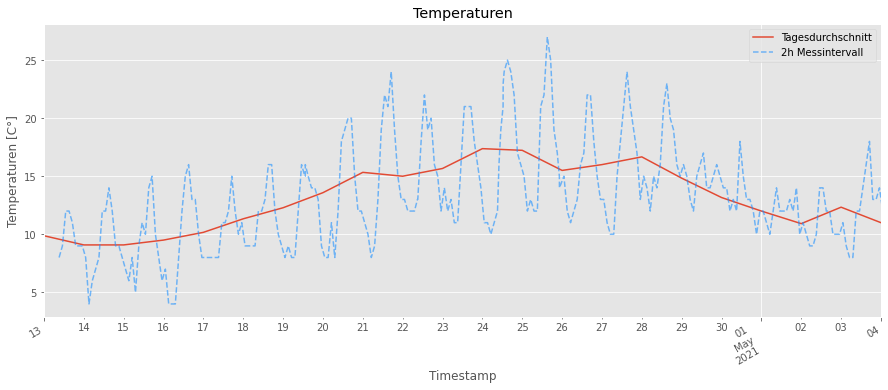

In [14]:
# Temperaturen
df_sensoneo['Temperatur'].resample('D').mean().plot(figsize=(15,6), label='Tagesdurchschnitt')
df_sensoneo['Temperatur'].plot(figsize=(15,6), color='dodgerblue', alpha=0.6, linestyle='--', label='2h Messintervall')
plt.title('Temperaturen')
plt.ylabel('Temperaturen [C°]')
plt.legend()
plt.show()

Nach prüfen Wetterdaten für den Raum Zürich besteht ein Offset der Temperatur, der Verlauf stimmt aber überrein (max zwischen 24.04 und 28.04) [link](https://www.accuweather.com/de/ch/zurich/316622/april-weather/316622)

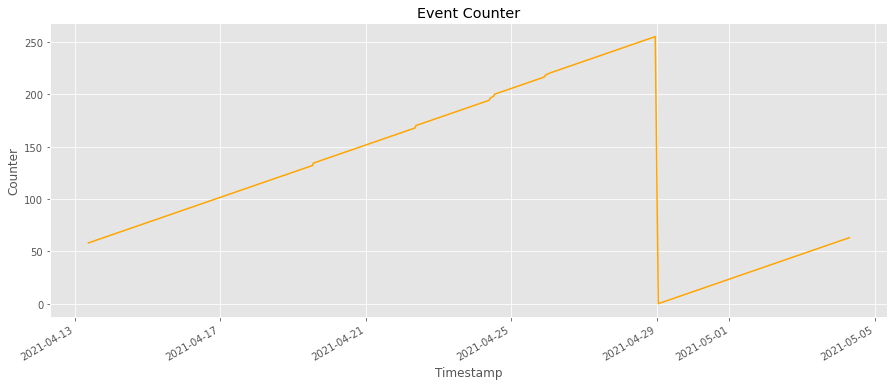

In [15]:
# Event Counter
df_sensoneo['Event Count'].plot(color='orange', figsize=(15,6))
plt.title('Event Counter')
plt.ylabel('Counter')
plt.show()

Event Counter von 255 zurück auf 0 -> Falls Messwerte vermisst werden auf diff() prüfen.

In [16]:
# pandas slicing mit sollte direkt möglich sein ..?
#df_sensoneo['2021-04-28':'2021-04-29']
df_sensoneo.loc['2021-4-23'][2:6]

,Data,Device ID,Distance,Temperatur,Spannung mV,Event Count
Timestamp,,,,,,
2021-04-23 19:06:21,b92a007001080808087012bb,0034EF62,16,18,3620,187
2021-04-23 17:06:20,b92a007001090909097015ba,0034EF62,18,21,3620,186
2021-04-23 15:06:19,b92a0070013b3b3b3b7015b9,0034EF62,118,21,3620,185
2021-04-23 13:06:18,b92a0070013a3a3a3a7015b8,0034EF62,116,21,3620,184


#### Interpretationen
Die Distanz von 120cm wird gemessen wenn der WC Deckel offen bleibt (für jeweils Türe offen/geschlossen). Die min. Distanz bei leerem Behälter war vor Ort ~41cm. Sensor Installation am 26. März, Messdaten aber erst seit Callbacks auf Sigfox Plattform vorhanden !?  
Messwerte grösse 100cm können entfernt werden. -> WC Deckel nicht zu  
Messwerte kleiner 5 können entfernt werden. -> Personen sitzt auf dem WC

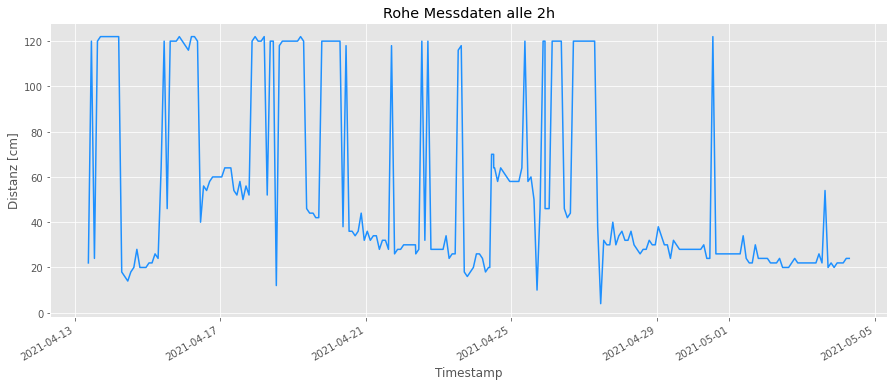

In [17]:
df_sensoneo['Distance'].plot(color='dodgerblue', figsize=(15,6))
plt.title('Rohe Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.show()

In [18]:
# Daten filtern und entfernen
df_sensoneo = df_sensoneo[df_sensoneo['Distance'] < 100]
df_sensoneo = df_sensoneo[df_sensoneo['Distance'] > 5]

#### Distanz Messdaten prüfen

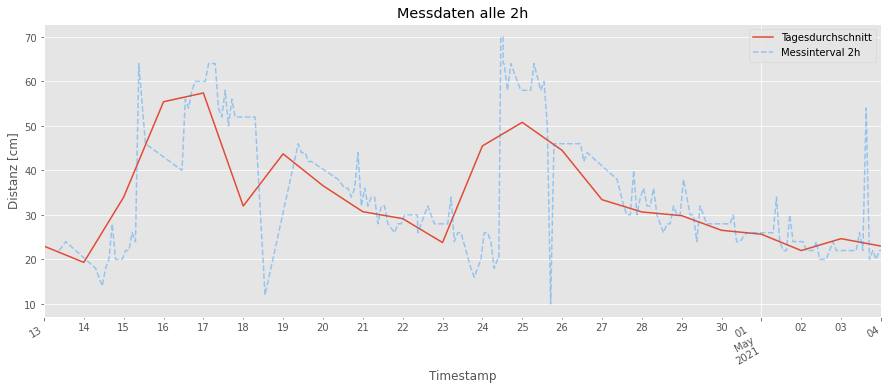

In [19]:
df_sensoneo['Distance'].resample('D').mean().plot(label='Tagesdurchschnitt')
df_sensoneo['Distance'].plot(color='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h')
plt.title('Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.show()

### Extended data cleaning
Aussreisser besser eingrenzen. Wenn Distanz bei leerem Behälter (max) 41cm ist, dann alle Messwerte grösser ~45cm entfernen. -> WC Deckel offen und Pissoir besetzt = Messung 70cm. Annahme das WC nicht voll wird, min = 12
Unklarheiten: Zeitraum 15.04 - 18.04 warum Wert grösser als 45cm 

In [20]:
df_sensoneo = df_sensoneo[df_sensoneo['Distance'] < 45]
df_sensoneo = df_sensoneo[df_sensoneo['Distance'] > 5] # 12 entfernt zu viele Daten

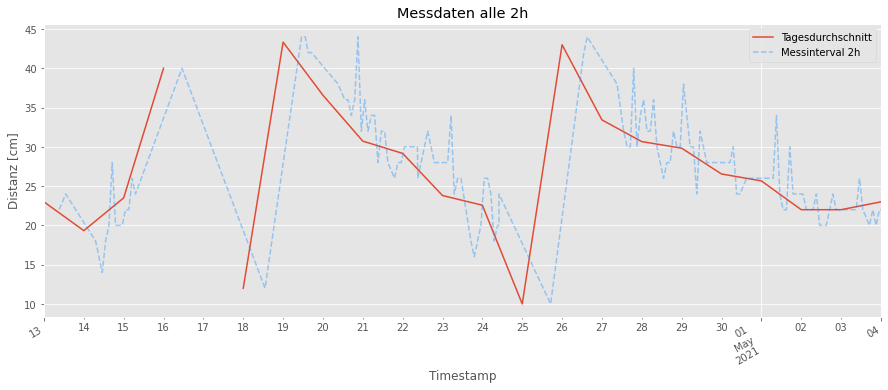

In [21]:
# Alle Wochentage
df_sensoneo['Distance'].resample('D').mean().plot(label='Tagesdurchschnitt')
df_sensoneo['Distance'].plot(color='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h')
plt.title('Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.show()

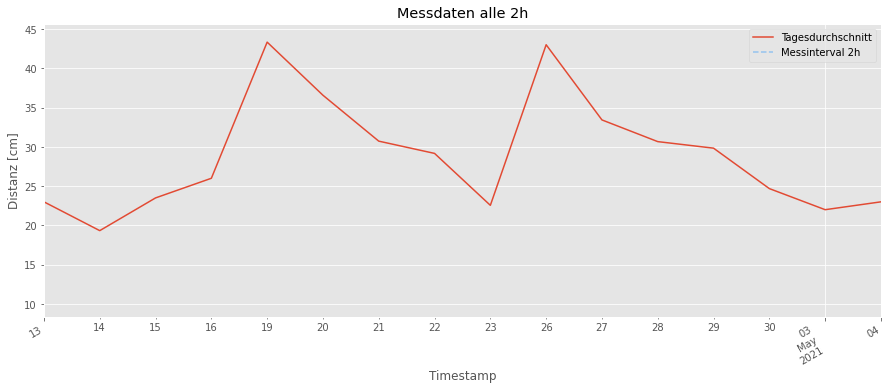

In [23]:
# Arbeitstage (ohne Wochenende)
df_sensoneo['Distance'].resample('B').mean().plot(label='Tagesdurchschnitt')
df_sensoneo['Distance'].plot(color='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h')
plt.title('Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.show()
# Leerungen können auch am Wochenende stattfinden daher nicht geeignet, zeigt aber Wochenende an.

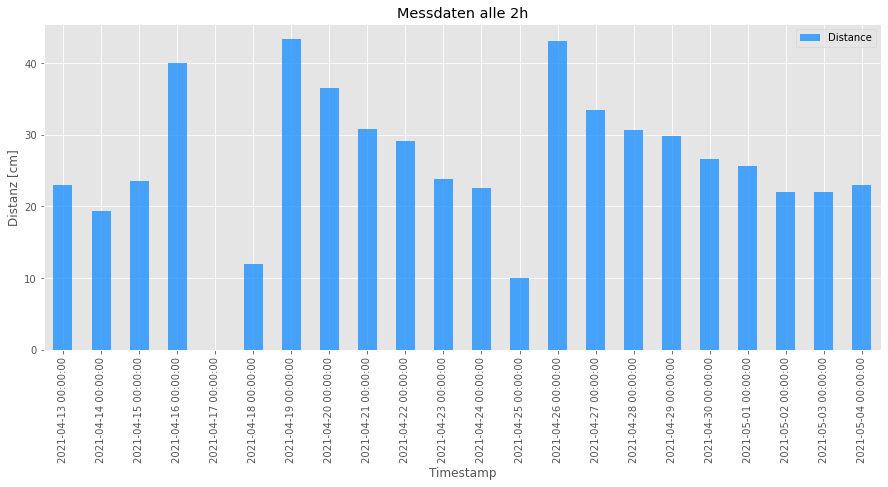

In [30]:
df_sensoneo['Distance'].resample('D').mean().plot(kind='bar', color='dodgerblue', figsize=(15,6), alpha=0.8)
#df_sensoneo['Distance'].plot(kindcolor='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h')
plt.title('Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.show()

### Fazit
Einzelne Messungen sind schwer zu interpretieren da der WC-Deckel beweglich ist und in allen möglichen Kombinationen messen kann. Nach dem Filtern der Daten zeigt die durchschnittliche Tages Messung wohl die besten Trends. (Vorsichtige) Schätzung würden auf eine Leerung am 18.04 und 25.04 hindeuten 

Messmöglichkeiten (nicht komplett):
1. Deckel ist geschlossen und misst Behälter Füllstand (ideal)
2. Deckel wurde nicht geschlossen und keine Person ist anwesende (Türe offen zu isst egal) misst ~120cm (filterbar)
3. Deckel wurde nicht geschlossen und misst eine Person am Urinal (problematisch)
4. Deckel ist nicht geschlossen da eine Person auf der Toilette sitzt, Distanz sehr klein (filterbar)

#### Weitere Möglichkeiten
Alarmierung bei unterschreiten einer Distanz

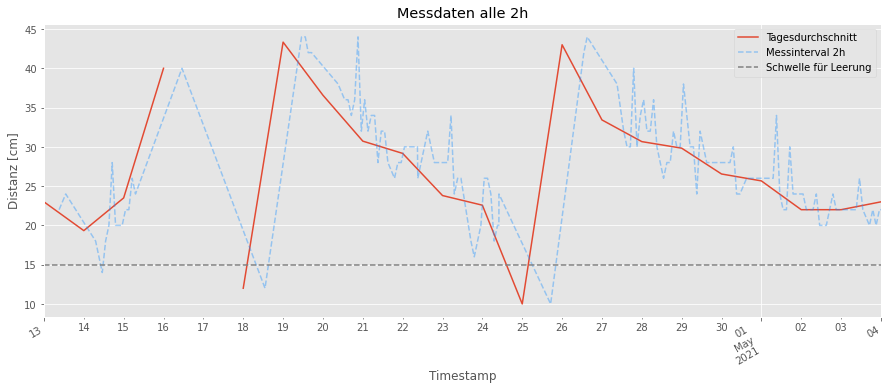

In [42]:
df_sensoneo['Distance'].resample('D').mean().plot(label='Tagesdurchschnitt')
df_sensoneo['Distance'].plot(color='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h')
plt.axhline(15, color='gray',linestyle='--', label='Schwelle für Leerung')
plt.title('Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.show()